### Cifar Dataset Classification using MLP and CNN 

The main goal here was to achieve the high accuracy using a simple network which should consist of only 2-3 layers 

In [1]:
import numpy as np
import pickle

class DataLoader:
    @staticmethod
    def __load_pickle_file(filename):
        '''
        This function reads the given pickle file in the current directory
        and returns a dictionary object.
        :param filename - the pickle file name.
        '''
        with open(filename, 'rb') as f:
            dict = pickle.load(f, encoding='bytes')
            return dict  

    @staticmethod
    def load_batch(filename_prefix, Nbatches=5,
                   height=32, width=32, Nchannels=3):


        if Nbatches == 1:
            batch = DataLoader.__load_pickle_file(filename_prefix)
            X = np.rollaxis(np.reshape(batch[b'data'], (-1,Nchannels,height,width)),
                            1, 4).astype('float32')
            y = np.array(batch[b'labels'], dtype='uint8')
        else:
            batch_no = range(1, Nbatches+1)  # the batch numbers start at 1
            # Read all the batch pickle files
            batch = [DataLoader.__load_pickle_file(filename_prefix+'_'+str(b)) for b in batch_no]

            batch_size = [len(batch[i][b'labels']) for i in range(Nbatches)]
            dataset_size = np.sum(batch_size)
    
            X = np.zeros((dataset_size, height, width, Nchannels), dtype='float32')
            y = np.zeros(dataset_size, dtype='uint8')
            loc = 0
            for i in range(Nbatches):
                X[loc:(loc+batch_size[i])] = np.rollaxis(
                    np.reshape(batch[i][b'data'], (-1,Nchannels,height,width)), 1, 4)
                y[loc:(loc+batch_size[i])] = batch[i][b'labels']
                loc += batch_size[i]
        return X/255, y


#### Step 1: Import the `DataLoader` class

In [3]:
# from data_loader import DataLoader
import random
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

#### Step 2: Call the `load_batch` function

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/cifar-10-batches-py.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
# According to the CIFAR-10 website, the training set is split into five batches
# stored in fives files. Each colour image has dimensions equal to 32 x 32 x 3. There
# are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The default values of all the arguments of the load_batch function have been
# set for the CIFAR-10 dataset.
X_train, y_train = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)

#### Step 3. A quick inspection of the outputs from the `load_batch` function

In [7]:
# You need to split the training set to form a validation set. The original
# training set would become smaller.
# *********data SPlitting ******************
indices = list(  range(len(X_train))  )
random.shuffle(indices)

split = int( 0.8 * len(indices) )
X_val, y_val = X_train[ indices[split:] ], y_train[  indices[split:] ]
xtrain, ytrain = X_train[ indices[:split] ], y_train[ indices[:split] ]

print('X_train.shape =', xtrain.shape, 'data type:', X_train.dtype)
print('y_train.shape =', ytrain.shape, 'data type:', y_train.dtype)

print('X_val.shape =', X_val.shape, 'data type:', X_val.dtype)
print('y_val.shape =', y_val.shape, 'data type:', y_val.dtype)


X_train.shape = (40000, 32, 32, 3) data type: float32
y_train.shape = (40000,) data type: uint8
X_val.shape = (10000, 32, 32, 3) data type: float32
y_val.shape = (10000,) data type: uint8


In [8]:
print('X_test.shape =', X_test.shape, 'data type:', X_test.dtype)
print('y_test.shape =', y_test.shape, 'data type:', y_test.dtype)

X_test.shape = (10000, 32, 32, 3) data type: float32
y_test.shape = (10000,) data type: uint8


<h2> Task 2: Randomly Displaying images </h2>

In [9]:
def randomly_display(dataset, labels):
  ind = list( range(len(dataset)) )
  ind = random.sample(ind, 20)

  fig=plt.figure(figsize=(10, 8))

  for i in range(1,21):
    fig.add_subplot(5, 4, i)
    plt.imshow(dataset[ind[i-1]])
    plt.title('CLass: {}'.format( class_names[ labels[ ind[i-1] ] ] ))

  plt.tight_layout()

<h3> Training Images</h3>

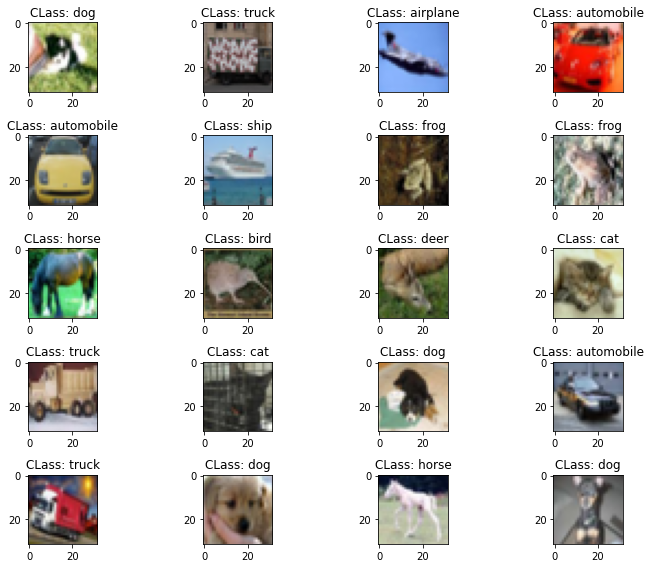

In [10]:
randomly_display(xtrain, ytrain)

<h3> Validation Images</h3>

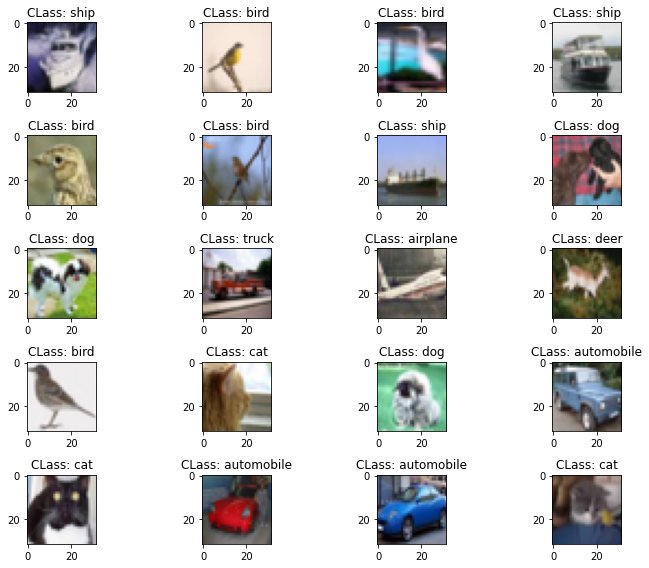

In [11]:
randomly_display(X_val, y_val)

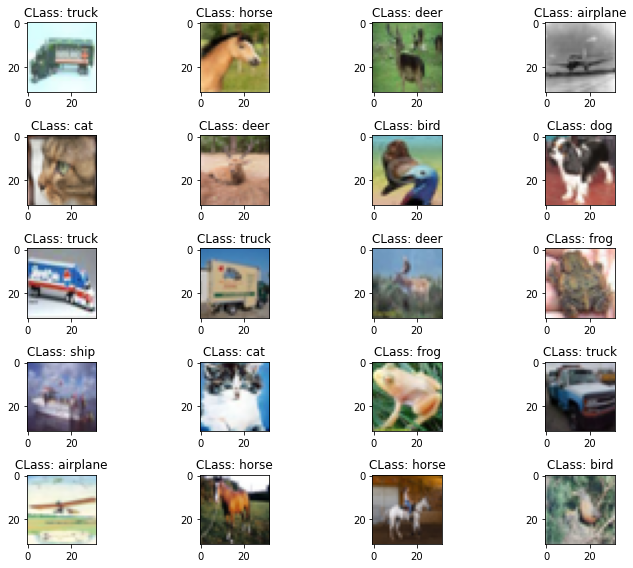

In [12]:
randomly_display(X_test, y_test)

<h2>Multi-Layer Perceptron (MLP) </h2>

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

import tensorflow as tf

In [17]:
def mlp_model(drop_rate=0.6, init='random_normal'):
  model = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(512, activation='relu', kernel_initializer=init),
    Dropout(rate=drop_rate),
    Dense(256, activation='tanh', kernel_initializer=init),
    # Dropout(rate=drop_rate),
    Dense(32, activation='relu', kernel_initializer=init),
    Dense(10, activation='softmax')                      
  ])
  # optim = tf.keras.optimizers.Adam( )
  model.compile(loss='sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

  return model
# model = mlp_model()
# model.summary()

Two kinds of learning schedulars are defined here: step and exponential

In [16]:
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import itertools

def step_lr_schedule(epoch, lr):
  if epoch %30 ==0:
    lr = lr/5
  return lr

def exp_lr_schedule(epoch):
   initial = 0.1
   lr = initial * np.exp(-0.1*epoch)
   return lr

step_lrate = tf.keras.callbacks.LearningRateScheduler(step_lr_schedule)
exp_lrate = tf.keras.callbacks.LearningRateScheduler(exp_lr_schedule)

A kind of grid search cv is also performed in order to obtain the hyper parameters but only two option for each were used as the aim from the start was to keep the things simple.

In [18]:
drop_rate = [0.2, 0.3]
init = ['random_normal', 'glorot_normal']
callback_dict = { 'step rate': step_lrate, 'Exponential Rate ': exp_lrate}
f1scores = []
combinations = list(itertools.product(drop_rate,init,callback_dict.keys()) )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7,
                               verbose=0, mode='auto')

for comb in combinations:

  dpr, initialize, call = comb
  print('\nTraining for drop rate: {}, weight initializer: {}, callbacks: {}\n'.format(dpr, initialize, call))
  call = callback_dict[call]

  model = mlp_model(dpr, initialize )
  history = model.fit(xtrain, ytrain, \
                      validation_data=(X_val, y_val), epochs=100,\
                      batch_size=512, callbacks=[call, early_stopping] )
  
  pred = model.predict_classes(X_val)
  f1scores.append( f1_score(y_val, pred, average='weighted')  )


Training for drop rate: 0.2, weight initializer: random_normal, callbacks: step rate

Epoch 1/100
79/79 [==============================] - 4s 12ms/step - loss: 2.1739 - accuracy: 0.2022 - val_loss: 1.8751 - val_accuracy: 0.3263
Epoch 2/100
79/79 [==============================] - 1s 7ms/step - loss: 1.8728 - accuracy: 0.3329 - val_loss: 1.7395 - val_accuracy: 0.3922
Epoch 3/100
79/79 [==============================] - 1s 8ms/step - loss: 1.7547 - accuracy: 0.3752 - val_loss: 1.6799 - val_accuracy: 0.3977
Epoch 4/100
79/79 [==============================] - 1s 8ms/step - loss: 1.6883 - accuracy: 0.3946 - val_loss: 1.6091 - val_accuracy: 0.4270
Epoch 5/100
79/79 [==============================] - 1s 7ms/step - loss: 1.6308 - accuracy: 0.4164 - val_loss: 1.5645 - val_accuracy: 0.4405
Epoch 6/100
79/79 [==============================] - 1s 7ms/step - loss: 1.5841 - accuracy: 0.4378 - val_loss: 1.5599 - val_accuracy: 0.4412
Epoch 7/100
79/79 [==============================] - 1s 7ms/step -

In [19]:
max_ind = np.argmax(f1scores)
sel_par = combinations[max_ind]
print('Best parameters selected for problem on hand are \ndrop rate: {}, weight initializer: {}, learning scheduler: {}\
        '.format(sel_par[0], sel_par[1], sel_par[2]) )


Best parameters selected for problem on hand are 
drop rate: 0.2, weight initializer: random_normal, learning scheduler: step rate        


<h4> Storing and Restoring Model for predition (Task 5)</h4>

In [20]:
import os
dir = './Surname FirstName-MLP'

# dir = os.path.join("C:\\","temp","python")
if os.path.exists(dir) and 'mlp_model.h5' in os.listdir(dir):
  model_mlp = tf.keras.models.load_model('./Surname FirstName-MLP/mlp_model.h5')
  print(model_mlp.summary())
  model_mlp.fit(xtrain, ytrain, \
                      validation_data=(X_val, y_val ), epochs=1,\
                      batch_size=512, callbacks=[step_lrate] )
  
else:
  if not os.path.exists(dir):
    os.mkdir(dir)
  model_mlp = mlp_model(0.4, 'glorot_normal' )
  model_mlp.summary()
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7,
                               verbose=0, mode='auto')
  model_mlp.fit(xtrain, ytrain, \
                      validation_data=(X_val, y_val ), epochs=100,\
                      batch_size=512, callbacks=[step_lrate, early_stopping] )
  model_mlp.save('./Surname FirstName-MLP/mlp_model.h5')
  
# 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_34 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_35 (Dense)             (None, 10)                330       
Total params: 1,713,258
Trainable params: 1,713,258
Non-trainable params: 0
____________________________________________

In [21]:
pred = model_mlp.predict_classes( X_test )
print(classification_report(y_test, pred, target_names=class_names))

print('\n*************confusion Matrix**************')
print(confusion_matrix(y_test, pred ))


              precision    recall  f1-score   support

    airplane       0.61      0.58      0.60      1000
  automobile       0.66      0.65      0.65      1000
        bird       0.44      0.34      0.39      1000
         cat       0.36      0.32      0.34      1000
        deer       0.48      0.44      0.46      1000
         dog       0.43      0.40      0.41      1000
        frog       0.52      0.67      0.58      1000
       horse       0.57      0.62      0.59      1000
        ship       0.63      0.69      0.66      1000
       truck       0.59      0.61      0.60      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000


*************confusion Matrix**************
[[581  32  52  26  38  18  29  26 147  51]
 [ 34 645  10  20   5  20  11  27  68 160]
 [ 72  20 344  87 141  88 128  79  19  22]
 [ 29  22  76 319  46 205 165  69  26  43]
 [ 56  10 116  56 440  4

In [22]:
# to display some correctly and incorrectly classified examples
correct_ind, incorrect_ind = [], []
for i in range(len(pred)):
  if pred[i] == y_test[i]:
    correct_ind.append(i)
  else:
    incorrect_ind.append(i)

  if len(correct_ind) > 20 and len(incorrect_ind) > 20:
    break

def display_pred(dataset, ind):

  fig=plt.figure(figsize=(10, 8))

  for i in range(1,21):
    fig.add_subplot(5, 4, i)
    plt.imshow(dataset[ind[i-1]])
    # plt.title('CLass: {}'.format( class_names[ labels[ ind[i-1] ] ] ))
  plt.tight_layout()

<h4>Correctly CLassified </h4>

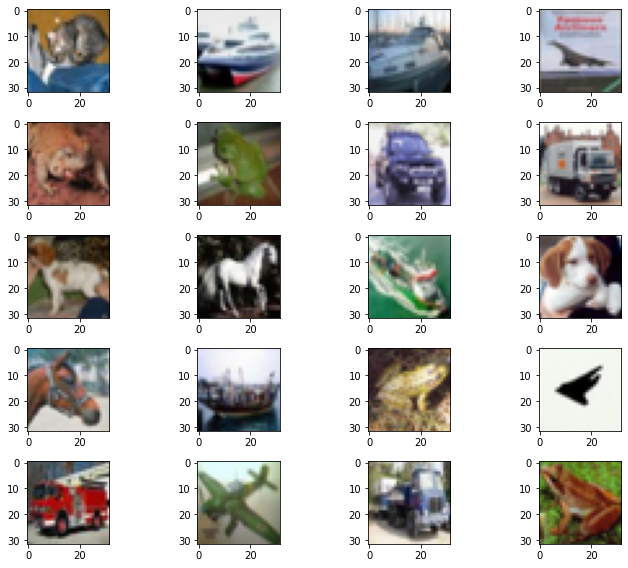

In [23]:
display_pred(X_test, correct_ind)

<h4>Incorrectly Classified </h4>

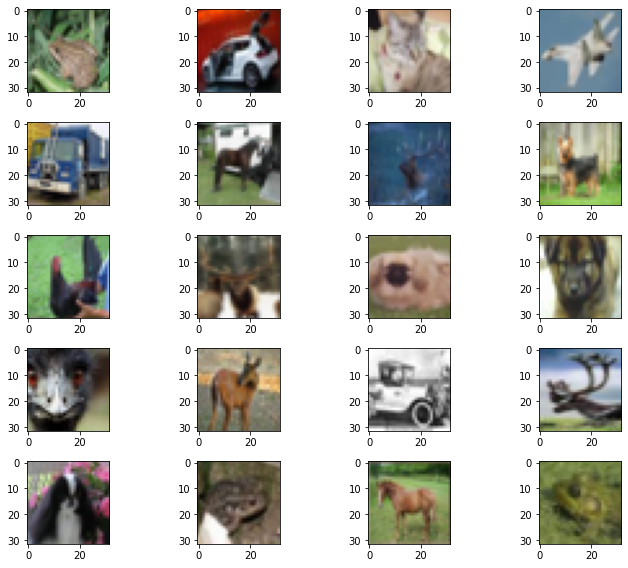

In [24]:
display_pred(X_test, incorrect_ind)

<h2><b> Convolutional Neural Network </b></h2>

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
def step_lr_schedule(epoch, lr):
  if epoch %10 ==0:
    lr = lr/5
  return lr

step_lrate = tf.keras.callbacks.LearningRateScheduler(step_lr_schedule)

In [ ]:
from tensorflow.keras.regularizers import L2
def cnn_model(kernel_size=3, kn= 32, af='relu' ):
  model = Sequential([
    
    Conv2D(kn*2, (kernel_size, kernel_size),kernel_initializer='glorot_normal',activation=af, padding='same', input_shape=(32, 32, 3) ),
    MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    Dropout(0.4),
    Conv2D(kn, (kernel_size, kernel_size), kernel_initializer='glorot_normal', activation=af, padding='same', kernel_regularizer=L2(0.05)),
    MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Dropout(0.3),
    # Conv2D(kn/2, (kernel_size, kernel_size), kernel_initializer='glorot_normal', activation=af, padding='same'),
    # MaxPooling2D((2, 2)),
    # tf.keras.layers.BatchNormalization(),

    Flatten(),
    Dropout(0.4),
    Dense(256, activation=af, kernel_initializer='glorot_normal',  kernel_regularizer=L2(0.05)),
    tf.keras.layers.BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation=af, kernel_initializer='glorot_normal', kernel_regularizer=L2(0.05)),
    
    # Dropout(0.2),
    # Dense(64, activation=af, kernel_initializer='glorot_normal'),
    
    Dense(10, activation='softmax')                      
  ])
  # optim = tf.keras.optimizers.Adam( )
  model.compile(loss='sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

  return model

# model = cnn_model(5, 128)
# model.summary()

In [ ]:
kernel_size = [3, 5]
kernel_number = [128, 256]
activation_function = ['relu', 'tanh']
f1scores = []
combinations = list(itertools.product(kernel_size,kernel_number, activation_function) )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7,
                               verbose=0, mode='auto')

for comb in combinations:

  ks, kn, af = comb
  print('\nTraining for Kernel size: {}, Number of kernels: {}, activation function: {}\n'\
        .format(ks, kn, af))

  model = cnn_model(ks, kn, af )
  history = model.fit(xtrain, ytrain, \
                      validation_data=(X_val, y_val), epochs=100,\
                      batch_size=512, callbacks=[step_lrate, early_stopping] )
  
  pred = model.predict_classes(X_val)
  f1scores.append( f1_score(y_val, pred, average='weighted')  )


Training for Kernel size: 3, Number of kernels: 128, activation function: relu

Epoch 1/100
79/79 [==============================] - 11s 91ms/step - loss: 38.2345 - accuracy: 0.2577 - val_loss: 23.1607 - val_accuracy: 0.1353
Epoch 2/100
79/79 [==============================] - 6s 78ms/step - loss: 18.9864 - accuracy: 0.4488 - val_loss: 14.0094 - val_accuracy: 0.1002
Epoch 3/100
79/79 [==============================] - 6s 77ms/step - loss: 10.3344 - accuracy: 0.5386 - val_loss: 10.0068 - val_accuracy: 0.1002
Epoch 4/100
79/79 [==============================] - 6s 78ms/step - loss: 6.4138 - accuracy: 0.5913 - val_loss: 7.9345 - val_accuracy: 0.1002
Epoch 5/100
79/79 [==============================] - 6s 78ms/step - loss: 4.4123 - accuracy: 0.6454 - val_loss: 7.2309 - val_accuracy: 0.1099
Epoch 6/100
79/79 [==============================] - 6s 78ms/step - loss: 3.2727 - accuracy: 0.6792 - val_loss: 6.0527 - val_accuracy: 0.1063
Epoch 7/100
79/79 [==============================] - 6s 78ms

In [ ]:
max_ind = np.argmax(f1scores)
sel_par = combinations[max_ind]
print('Best parameters selected for problem on hand are \nkernel size: {}, number of kernels: {}, activation function: {}\
        '.format(sel_par[0], sel_par[1], sel_par[2]) )


Best parameters selected for problem on hand are 
kernel size: 5, number of kernels: 256, activation function: relu        


<h4> Storing and Restoring Model for predition (Task 5)</h4>

In [ ]:
import os

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7,
                               verbose=0, mode='auto')
dir = './Surname FirstName-CNN'
# dir = os.path.join("C:\\","temp","python")
if os.path.exists(dir) and 'cnn_model.h5' in os.listdir(dir):
  model_cnn = tf.keras.models.load_model('./Surname FirstName-CNN/cnn_model.h5')
  print(model_cnn.summary())
  model_cnn.fit(xtrain, ytrain, \
                      validation_data=(X_val, y_val ), epochs=1,\
                      batch_size=512, callbacks=[step_lrate] )
  
else:
  if not os.path.exists(dir):
    os.mkdir(dir)
  model_cnn = cnn_model(kernel_size=5, kn= 256, af='relu')
  model_cnn.summary()
  model_cnn.fit(xtrain, ytrain, \
                      validation_data=(X_val, y_val ), epochs=100,\
                      batch_size=512, callbacks=[step_lrate, early_stopping] )
  model_cnn.save('./Surname FirstName-CNN/cnn_model.h5')
  
# 

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 512)       38912     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 512)       0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 16, 16, 512)       2048      
_________________________________________________________________
dropout_40 (Dropout)         (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 256)       3277056   
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 8, 8, 256)       

In [ ]:
pred = model_cnn.predict_classes( X_test )
print(classification_report(y_test, pred, target_names=class_names))

print('\n*************confusion Matrix**************')
print(confusion_matrix(y_test, pred ))


              precision    recall  f1-score   support

    airplane       0.86      0.82      0.84      1000
  automobile       0.92      0.90      0.91      1000
        bird       0.78      0.70      0.74      1000
         cat       0.69      0.64      0.66      1000
        deer       0.75      0.83      0.79      1000
         dog       0.73      0.73      0.73      1000
        frog       0.81      0.90      0.86      1000
       horse       0.88      0.84      0.86      1000
        ship       0.89      0.91      0.90      1000
       truck       0.86      0.89      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000


*************confusion Matrix**************
[[823  12  34  18  22   5   6   4  47  29]
 [  7 896   2   4   3   4   7   2  13  62]
 [ 42   1 705  33  73  49  57  23  11   6]
 [ 11   3  39 639  60 140  66  18  12  12]
 [  7   2  36  37 827  1

In [ ]:
correct_ind, incorrect_ind = [], []
for i in range(len(pred)):
  if pred[i] == y_test[i]:
    correct_ind.append(i)
  else:
    incorrect_ind.append(i)

  if len(correct_ind) > 20 and len(incorrect_ind) > 20:
    break

<h4>Correctly Classified </h4>

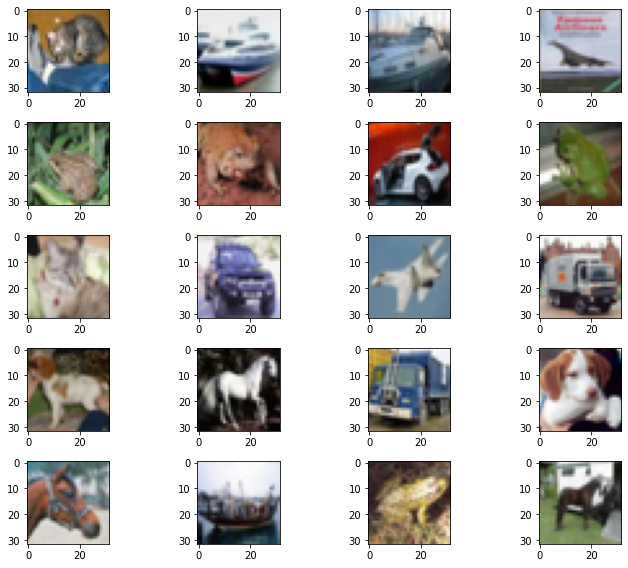

In [ ]:
display_pred(X_test, correct_ind)

<h4>Incorrectly Classified </h4>

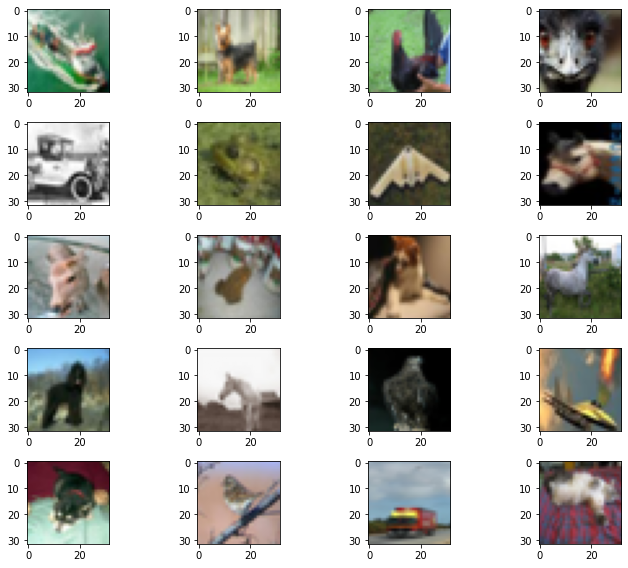

In [ ]:
display_pred(X_test, incorrect_ind)